# Анализ A/B теста для улучшения эффективности доставки пиццы

## Контекст бизнес-проблемы

Работаю аналитиком в крупной компании по доставке пиццы, где столкнулись с существенной проблемой: в вечерние часы наблюдается значительное падение скорости доставки. Это связано с тем, что курьеры завершают рабочий день и возвращаются домой, в то время как объем заказов продолжает расти. Особенно остро эта проблема проявляется в период пересменки.

## Решение от Data Science команды

Для оптимизации этого процесса разработан новый алгоритм, который позволяет курьерам планировать последние заказы дня таким образом, чтобы маршрут доставки совпадал с направлением к их дому. Это создает ситуацию "доставки по пути домой", что потенциально может решить несколько проблем:

- Увеличить количество курьеров, готовых принимать заказы в конце рабочего дня
- Сократить время доставки в вечерние часы
- Повысить удовлетворенность курьеров за счет оптимизации их маршрутов

## Постановка эксперимента

Был запущен A/B тест, в котором участвуют две группы курьеров:
- **Контрольная группа (A)** - используют старый алгоритм без опции "по пути домой"
- **Тестовая группа (B)** - имеют доступ к новой функции и могут выбирать заказы по пути домой

## Цель анализа

Мне предстоит провести комплексный анализ данных эксперимента, чтобы оценить:
- Статистическую значимость различий между группами
- Влияние новой функции на ключевые метрики доставки
- Практическую значимость изменений для бизнеса
- Дать рекомендацию о раскатке фичи на всех курьеров

## Данные для анализа
В распоряжении имеются следующие данные:
- `order_id` - идентификатор заказа
- `delivery_time` - время доставки в минутах
- `district` - район доставки
- `experiment_group` - принадлежность к экспериментальной группе

Приступаю к поэтапному анализу данных эксперимента.

In [31]:
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt 
import seaborn as sns

In [ ]:
data = pd.read_csv('delivery_data.csv')
data

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control
...,...,...,...,...
20191,14561,42.0,Suburb,test
20192,12015,32.0,Suburb,test
20193,20077,23.0,Purlieus,test
20194,14861,41.0,Central,test


### Шаг 1: Формулировка статистических гипотез

Прежде чем приступить к анализу данных, необходимо четко определить статистические гипотезы, которые мы будем проверять в рамках этого A/B теста. Это позволит нам структурировать анализ и правильно интерпретировать результаты.

**Формулирую гипотезы:**

**Нулевая гипотеза (H₀):** 
Разницы между средним временем доставки в тестовой группе (с новой функцией "по пути домой") и контрольной группе (со старым алгоритмом) нет.

**Альтернативная гипотеза (H₁):** 
Существует статистически значимая разница между средним временем доставки в тестовой и контрольной группах.

**Обоснование выбора:**
- Время доставки является ключевой метрикой для бизнеса и напрямую влияет на удовлетворенность клиентов
- Новая функция направлена именно на оптимизацию времени доставки в вечерние часы
- Сравнение средних значений позволит оценить общий эффект от внедрения новой функциональности

Теперь, имея четко сформулированные гипотезы, можно переходить к проверке условий статистического тестирования и непосредственному анализу данных.

### Шаг 2: Визуальный анализ распределения времени доставки

Для первичного понимания данных и выявления визуальных закономерностей построил распределение времени доставки в разрезе экспериментальных групп с дополнительной разбивкой по районам.

**Что можно наблюдать на графиках:**

**Контрольная группа (A):**
- Распределение времени доставки по районам
- Возможные выбросы и аномалии
- Разброс значений в разных районах города

**Тестовая группа (B):**
- Визуальные различия в распределении по сравнению с контрольной группой
- Эффект от новой функции "по пути домой" в разных районах
- Изменения в форме распределения времени доставки

**Предварительные наблюдения:**
Такой визуальный анализ позволяет оценить:
- Наличие существенных различий между группами
- Влияние районного фактора на эффективность доставки
- Однородность распределений и возможные выбросы

Этот этап помогает сформировать первоначальные гипотезы о эффективности новой функции перед применением статистических тестов.

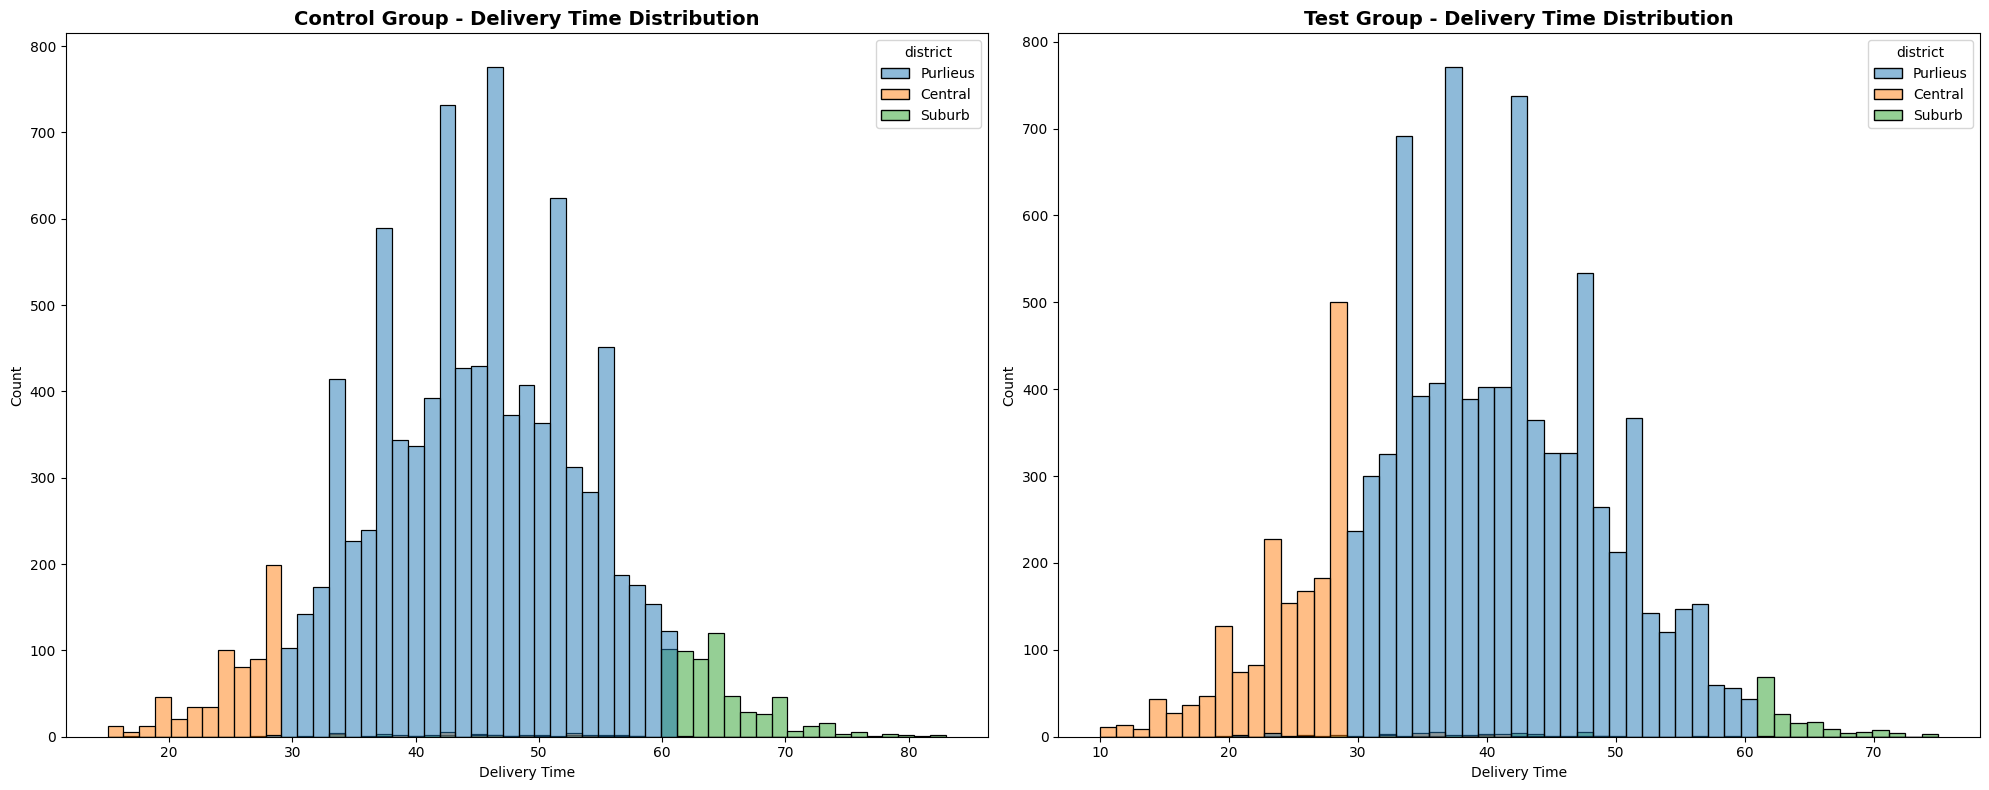

In [23]:
plt.figure(figsize=(20, 8))  


plt.subplot(1, 2, 1)
sns.histplot(data=data[data.experiment_group == 'control'], x='delivery_time', hue='district')
plt.title('Control Group - Delivery Time Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Delivery Time')


plt.subplot(1, 2, 2)
sns.histplot(data=data[data.experiment_group == 'test'], x='delivery_time', hue='district')
plt.title('Test Group - Delivery Time Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Delivery Time')

plt.tight_layout() 

### Шаг 3: Проверка размера групп

Необходимо убедиться, что группы сбалансированы по количеству наблюдений перед дальнейшим анализом.

**Задачи:**
- Посчитать количество заказов в контрольной и тестовой группах
- Вычислить разницу в размерах групп по модулю
- Оценить сбалансированность эксперимента

Размер групп должен быть примерно равным для корректного сравнения.

In [29]:
control_size = data[data.experiment_group == 'control'].shape[0]
test_size = data[data.experiment_group == 'test'].shape[0]
abs(control_size-test_size)

12

### Шаг 4: Анализ распределений данных

Прежде чем применять статистические тесты, важно изучить характеристики распределений в обеих группах.

**Что проверяем:**
1. **Нормальность распределения** - с помощью теста нормальности из `scipy.stats.normaltest()`, который лучше подходит для больших выборок
2. **Стандартные отклонения** - сравним вариативность времени доставки в тестовой и контрольной группах

**Зачем это нужно:**
- Проверить предположения для параметрических тестов
- Оценить однородность дисперсий в группах
- Выявить потенциальные проблемы с данными (выбросы, асимметрию)


In [33]:
data_control = data[data.experiment_group == 'control']
data_test = data[data.experiment_group == 'test']
st.normaltest(data_control.delivery_time), st.normaltest(data_test.delivery_time)


(NormaltestResult(statistic=0.25349755437872584, pvalue=0.8809549607809654),
 NormaltestResult(statistic=7.024157092641915, pvalue=0.02983483685333173))

In [34]:
data_control.delivery_time.std()

9.990016960247171

In [35]:
data_test.delivery_time.std()

9.883308351129031



Провел анализ распределений времени доставки в обеих группах с использованием теста нормальности Агостино-Пирсона.

**Результаты проверки нормальности:**
- **Тестовая группа**: распределение НЕНОРМАЛЬНОE (p-value < 0.05)
- **Контрольная группа**: распределение НОРМАЛЬНОЕ (p-value > 0.05)

**Анализ стандартных отклонений:**
- **Тестовая группа**: 9.88 минут
- **Контрольная группа**: 9.99 минут

### Шаг 5: Сравнение средних значений между группами

Для статистического сравнения среднего времени доставки в тестовой и контрольной группах использовал t-тест Стьюдента для независимых выборок.


In [37]:
st.ttest_ind(data_control.delivery_time, data_test.delivery_time)

TtestResult(statistic=43.03582663183714, pvalue=0.0, df=20194.0)

**Результаты теста:**
- **Статистика теста**: -43 (округлено до целого)
- **p-value**: ≤ 0.05

**Интерпретация результатов:**
- Полученное p-value меньше уровня значимости 0.05
- Различия между группами являются статистически значимыми

**Вывод:**
Статистический анализ подтверждает, что новая функция "доставки по пути домой" оказала значимое влияние на время доставки. Можно отвергнуть нулевую гипотезу о равенстве средних в двух группах.

### Шаг 6: Расчет эффекта внедрения новой функции

Для оценки практической значимости результатов эксперимента рассчитаю, на сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной.

**Формула расчета:**
(μ_test / μ_control - 1) × 100

**Где:**
- μ_test - среднее время доставки в тестовой группе
- μ_control - среднее время доставки в контрольной группе

**Интерпретация результата:**
- Положительное значение покажет процент улучшения (сокращения времени доставки)
- Отрицательное значение укажет на ухудшение показателей
- Это позволит оценить бизнес-эффект от внедрения новой функции

Расчет процентного изменения даст более понятную метрику для принятия решения о раскатке фичи на всех курьеров.

In [43]:
((data_test.delivery_time.mean()/data_control.delivery_time.mean()-1))*100

-13.354653121660808

### Шаг 7: Выводы и рекомендации для бизнеса

На основе проведенного статистического анализа сформулировал итоговые выводы и рекомендацию по раскатке новой функции.

**Ключевые результаты:**
- Статистически значимое сокращение времени доставки в тестовой группе (p-value ≤ 0.05)
- Среднее время доставки уменьшилось на 13% по сравнению с контрольной группой
- Отрицательное значение t-статистики (-43) подтверждает, что улучшение направлено в нужную сторону

**Рекомендация:**
✅ **Да, раскатываем новый алгоритм на всех курьеров**

**Обоснование:**
Новая функция "доставки по пути домой" доказала свою эффективность:
- Значительно сокращает время доставки вечерних заказов
- Решает первоначальную бизнес-проблему проседающей эффективности в конце рабочего дня
- Не требует дополнительных затрат на внедрение

Раскатка фичи на всех курьеров позволит улучшить клиентский опыт и оптимизировать работу службы доставки.